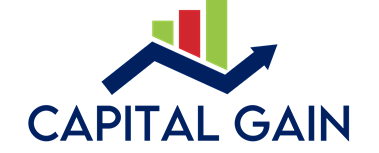
### ADMN5006: Financial Analytics
#### Final Project
Asharani Sukumaran Nair, Donovan Bangs, Maria Isabel Dio Grau, Xiuhao Shuai

***

### <b><span style="color:red"> **Add links</span></b>

<a href='#historical'>Historical Stock Performance</a><br>
<a href='#ratios'>Financial Ratios</a><br>
<a href='#corr'>Covariance and Correlation</a><br>
<a href='#montecarlo'>Monte Carlo Analysis</a><br>
<a href='#portfolio'>Portfolio Optimization</a><br>
<a href='#scenario'>Scenario Analysis</a><br>

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import yfinance as yfin
yfin.pdr_override()
import math
from scipy.stats import norm
import seaborn

In [2]:
# Setup

stocks = ['NVDA', 'ABBV', 'TTE', 'LUV']
N = 255 # Number of trading days
rf = 0.00833 #13-week US T-Bill rate as of April 26, 2022 (Yahoo Finance: ^IRX)


In [3]:
startdate = datetime(2013,1,1)
enddate = datetime(2019,12,31)



### <b><span style="color:red"> **ABBV went public in 2013. Look for comparable stock or change start date from 2010 to 2013?</span></b>

In [4]:
table = pdr.get_data_yahoo(stocks, data_source = 'yahoo', start = startdate, end = enddate)['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [5]:
table.head()

,ABBV,LUV,NVDA,TTE
Date,,,,
2013-01-02,23.783304,9.779124,2.939527,30.516876
2013-01-03,23.586908,10.012627,2.941837,30.290485
2013-01-04,23.288944,10.162067,3.038898,30.365944
2013-01-07,23.336353,10.190092,2.951081,30.006042
2013-01-08,22.828445,10.302167,2.886374,29.942192


### Historical Stock Performance

### Financial Ratios

In [6]:
df = table.pct_change().dropna()

In [7]:
df.head()

,ABBV,LUV,NVDA,TTE
Date,,,,
2013-01-03,-0.008258,0.023878,0.000786,-0.007419
2013-01-04,-0.012633,0.014925,0.032993,0.002491
2013-01-07,0.002036,0.002758,-0.028898,-0.011852
2013-01-08,-0.021765,0.010998,-0.021926,-0.002128
2013-01-09,0.005636,-0.002719,-0.022418,-0.000582


In [8]:
def sharpe_ratio(return_series,N,rf):
    mean=return_series.mean()*N-rf
    sigma=return_series.std()*np.sqrt(N)
    return mean/sigma

sharpes = df.apply(sharpe_ratio,args=(N,rf),axis=0)


In [9]:
def sortino_ratio(series,N,rf):
    mean=series.mean()*N-rf
    std_neg=series[series<0].std()*np.sqrt(N)
    return mean/std_neg

sortinos = df.apply(sortino_ratio,args=(N,rf,),axis=0)


In [10]:
def max_drawdown(return_series):
    comp_ret=(return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

max_drawdowns = df.apply(max_drawdown,axis=0)


In [11]:
calmars =df.mean()*N/abs(max_drawdowns)

In [12]:
pd.DataFrame([sharpes, sortinos, max_drawdowns, calmars],
             index=['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Calmar Ratio'])

,ABBV,LUV,NVDA,TTE
Sharpe Ratio,0.736370,1.017231,1.292505,0.345550
Sortino Ratio,0.945318,1.400368,1.822801,0.492753
Max Drawdown,-0.450898,-0.322948,-0.560384,-0.407697
Calmar Ratio,0.469027,0.880036,0.901361,0.206709


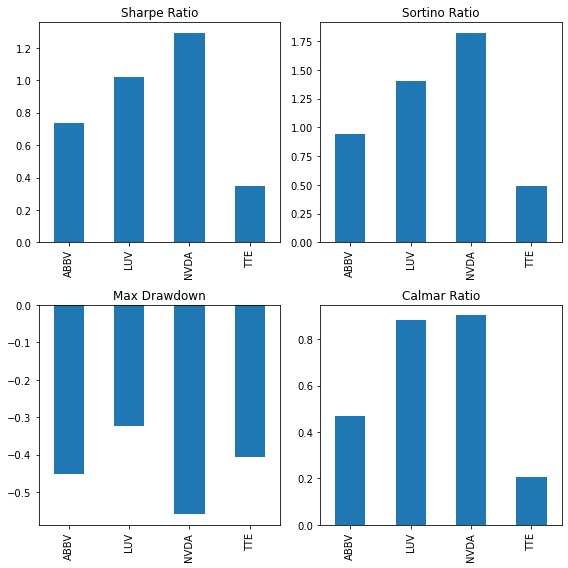

In [13]:
fig = plt.figure(figsize = [8,8])

plt.subplot(2, 2, 1)
plt.title('Sharpe Ratio')
sharpes.plot.bar()

plt.subplot(2, 2, 2)
plt.title('Sortino Ratio')
sortinos.plot.bar()

plt.subplot(2, 2, 3)
plt.title('Max Drawdown')
max_drawdowns.plot.bar()

plt.subplot(2, 2, 4)
plt.title('Calmar Ratio')
calmars.plot.bar()

fig.tight_layout()
plt.show()

### Correlation and Covariance

In [14]:
corrstartdate = datetime(2019,1,1)

A shorter timeframe is used for the correlation analysis. A longer timeframe will show strong positive correlations across all stocks since the broad market, including the stocks in this portfolio, increased significantly.

In [15]:
corrtable = pdr.get_data_yahoo(stocks, data_source = 'yahoo', start = corrstartdate, end = enddate)['Adj Close']
corr_df = corrtable.corr(method='pearson')

# Swap symbols as Index
corr_df.head().reset_index()
corr_df.head()

[*********************100%***********************]  4 of 4 completed


,ABBV,LUV,NVDA,TTE
ABBV,1.000000,0.353886,0.508402,0.462152
LUV,0.353886,1.000000,0.571682,0.244620
NVDA,0.508402,0.571682,1.000000,0.259492
TTE,0.462152,0.244620,0.259492,1.000000


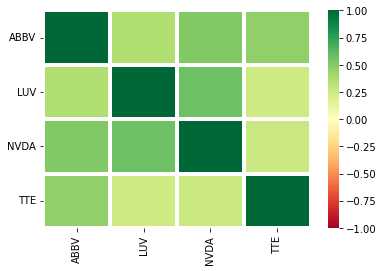

In [16]:
# Correlation Heatmap

seaborn.heatmap(corr_df, cmap='RdYlGn',vmax=1.0,vmin=-1.0,linewidths=2.1)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

### Monte Carlo Analysis

<b>NVDA</b>

In [26]:
# CAGR and volatility

days = (table.index[-1] - table.index[0]).days
cagr = ((((table['NVDA'][-1]) / table['NVDA'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr

table['NVDA Returns'] = table['NVDA'].pct_change()
vol = table['NVDA Returns'].std()*math.sqrt(252)
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

CAGR = 53.12%
Annual Volatility = 38.21%


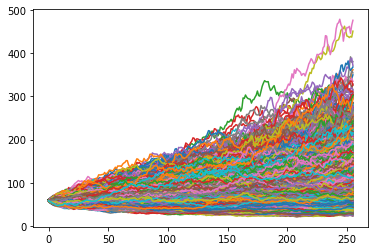

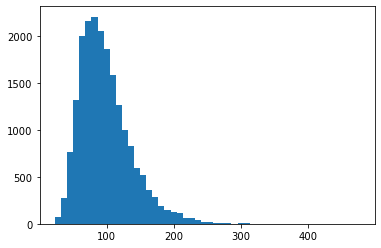

The average price of NVDA stock can be $98.43 in one year.


In [27]:
# Monte Carlo Simulation

result = []

S = table['NVDA'][-1] #starting stock price (i.e. last available real stock price)
mu = 0.5312 #Return
vol = 0.3821 #Volatility

for i in range(20000):
    # Create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/N,vol/math.sqrt(N),N)+1
    
    # Set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # Plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    
    # Append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

# Show the plot of multiple price series created above
plt.show()

# Create histogram of ending stock values for our mutliple simulations
plt.hist(result,bins=50)
plt.show()

print("The average price of NVDA stock can be $" + str(round(np.mean(result),2)) + " in one year.")

<b>ABBV</b>

In [28]:
# CAGR and volatility

days = (table.index[-1] - table.index[0]).days
cagr = ((((table['ABBV'][-1]) / table['ABBV'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr

table['ABBV Returns'] = table['ABBV'].pct_change()
vol = table['ABBV Returns'].std()*math.sqrt(252)
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

CAGR = 18.77%
Annual Volatility = 27.43%


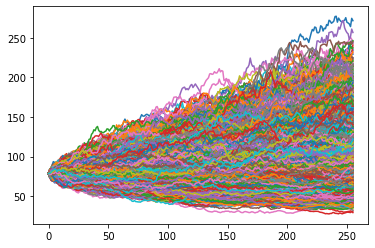

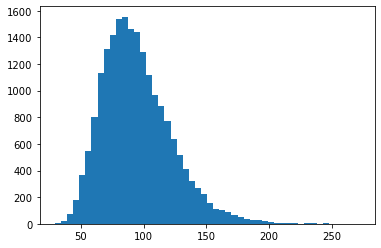

The average price of ABBV stock can be $94.66 in one year.


In [29]:
# Monte Carlo Simulation

result = []

S = table['ABBV'][-1] #starting stock price (i.e. last available real stock price)
mu = 0.1877 #Return
vol = 0.2843 #Volatility

for i in range(20000):
    # Create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/N,vol/math.sqrt(N),N)+1
    
    # Set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # Plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    
    # Append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

# Show the plot of multiple price series created above
plt.show()

# Create histogram of ending stock values for our mutliple simulations
plt.hist(result,bins=50)
plt.show()

print("The average price of ABBV stock can be $" + str(round(np.mean(result),2)) + " in one year.")

<b>TTE</b>

In [30]:
# CAGR and volatility

days = (table.index[-1] - table.index[0]).days
cagr = ((((table['TTE'][-1]) / table['TTE'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr

table['TTE Returns'] = table['TTE'].pct_change()
vol = table['TTE Returns'].std()*math.sqrt(252)
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

CAGR = 6.22%
Annual Volatility = 21.85%


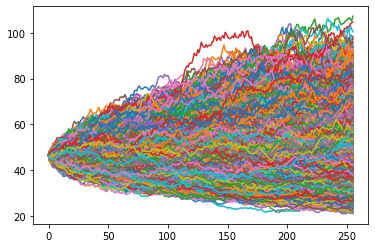

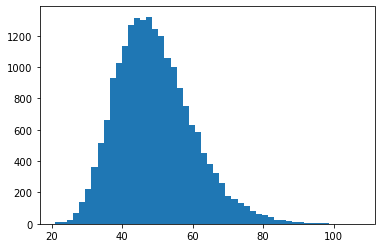

The average price of TTE stock can be $49.24 in one year.


In [31]:
# Monte Carlo Simulation

result = []

S = table['TTE'][-1] #starting stock price (i.e. last available real stock price)
mu = 0.0622 #Return
vol = 0.2185 #Volatility

for i in range(20000):
    # Create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/N,vol/math.sqrt(N),N)+1
    
    # Set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # Plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    
    # Append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

# Show the plot of multiple price series created above
plt.show()

# Create histogram of ending stock values for our mutliple simulations
plt.hist(result,bins=50)
plt.show()

print("The average price of TTE stock can be $" + str(round(np.mean(result),2)) + " in one year.")

<b>LUV</b>

In [34]:
# CAGR and volatility

days = (table.index[-1] - table.index[0]).days
cagr = ((((table['LUV'][-1]) / table['LUV'][1])) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")
mu = cagr

table['LUV Returns'] = table['LUV'].pct_change()
vol = table['LUV Returns'].std()*math.sqrt(252)
print ("Annual Volatility =",str(round(vol,4)*100)+"%")

CAGR = 27.200000000000003%
Annual Volatility = 26.96%


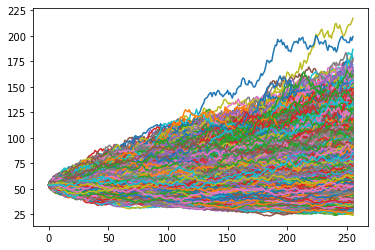

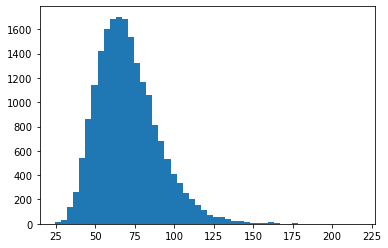

The average price of LUV stock can be $70.61 in one year.


In [35]:
# Monte Carlo Simulation

result = []

S = table['LUV'][-1] #starting stock price (i.e. last available real stock price)
mu = 0.2720 #Return
vol = 0.2696 #Volatility

for i in range(20000):
    # Create list of daily returns using random normal distribution
    daily_returns=np.random.normal(mu/N,vol/math.sqrt(N),N)+1
    
    # Set starting price and create price series generated by above random daily returns
    price_list = [S]
    
    for x in daily_returns:
        price_list.append(price_list[-1]*x)

    # Plot data from each individual run which we will plot at the end
    plt.plot(price_list)
    
    # Append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])

# Show the plot of multiple price series created above
plt.show()

# Create histogram of ending stock values for our mutliple simulations
plt.hist(result,bins=50)
plt.show()

print("The average price of LUV stock can be $" + str(round(np.mean(result),2)) + " in one year.")

In [ ]:
# Code from week 7; modify for scenario analysis

df = stocks.pct_change().dropna()
df['port']=df.mean(axis=1)
(df+1).cumprod().plot()

(df+1).cumprod()[-1:]

•	Understand & comment on the past performances of each stock in your portfolio.
•	Understand & comment on the covariance and correlation between each stock in your portfolio.
•	Perform price prediction using Monte Carlo analysis for each stock and comment on their outlook.
